In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import sys
sys.path.append("../python scripts/")
cwd = os.getcwd()
from mantid.simpleapi import *
import matplotlib
import matplotlib.patheffects as PathEffects
from cut_mdhisto_powder import cut_MDHisto_powder
from import_material_cif import *
import lmfit
import MDUtils as mdu
%matplotlib inline
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'


FrameworkManager-[Notice] Welcome to Mantid 6.7.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.7
CheckMantidVersion-[Notice] A new version of Mantid(6.9.0) is available for download from https://download.mantidproject.org
DownloadInstrument-[Notice] All instrument definitions up to date


## In order to calculate the normalization to absolute units, we refine Bragg Peak intensity 

In general, the intensity from a structural Bragg peak is given by 

$I_{bragg}(Q,\omega)=N\frac{(2\pi)^3}{V_0}\sum|F_{HKL}(Q)|^2 $

For a powder,


$\int 4\pi Q^2 I(Q,\omega) dQ d\omega = {\cal A}N\frac{(2\pi)^3}{V_0}|F_{HKL}(Q)|^2$

Where ${\cal A}$ is a normalization factor that may be fit. If we are normalizing to per unit cell and are only using a single-energy cut, then the expression becomes

$I(Q,\omega) \Delta_{FWHM}= {\cal A}\frac{(2\pi)^3}{V_0}\frac{|F_{HKL}(Q)|^2}{4\pi Q^2}$

The quantity ${\cal A}$ is now fit. 

In [2]:
def getQEdims(ws):
    dims = ws.getNonIntegratedDimensions()
    q,e=mdu.dim2array(dims[0]),mdu.dim2array(dims[1])
    return q,e

 Material.formula_weight=(val)
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.05 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.05 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.05 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.04 seconds
Min energy 3.7 meV = 0.11 meV
Min energy 5.0 meV = 0.03 meV
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


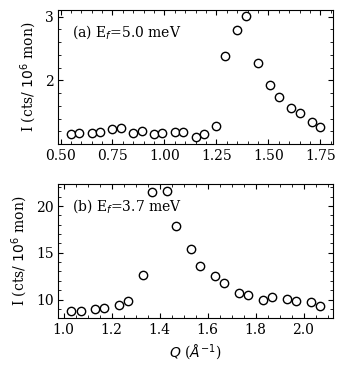

In [3]:
cifname = cwd+'/D3LiIr2O6.CIF'
alcifname = cwd+'/Aluminum.cif'
nist_file = cwd+'/nist_scattering_table.txt'

b_arr={}
b_arr['D']=['---','6.67','4.04','5.592','2.05','7.62','0'][1]
b_arr['H']=['---','-3.759','---','1.7568','80.26','82.03','0'][1]

b_arr['Li']=['92.5','-2.22','-2.49','.619','0.78','1.4','0.0454' ][1]
b_arr['Ir']=['---', '13.0', '---', '14.1', '0.(3.)', '14.(3.)', '425.(2.)'][1]
b_arr['O']='5.8'
abs_191 = 954.0
abs_193 = 111.0
abs_Ir = 0.94*abs_193 + 0.06*abs_191
abs_dict_LIO ={'Li':0.454,'Ir':abs_Ir,'O':0.00019,'H':0.0}
HLIO=Material(cifname,suppress_print=True,nist_data=nist_file,b_arr=b_arr)
HLIO.formula_weight=494.3


keys = ['2K_3p7','55K_3p7','2K_5p0','55K_5p0']
f_dict = {keys[0]:'../MDHisto_files/macs_3p7_2K_orig.nxs',\
         keys[1]:'../MDHisto_files/macs_3p7_55K_orig.nxs',\
         keys[2]:'../MDHisto_files/macs_5p0_2K_orig.nxs',\
         keys[3]:'../MDHisto_files/macs_5p0_55K_orig.nxs'}
#Import the data into workspaces. 
ws_dict = {}
Ef_dict = {keys[0]:3.7,keys[1]:3.7,keys[2]:5.0,keys[3]:5.0}
for key in keys:
    f = f_dict[key]
    ws = LoadMD(f,OutputWorkspace=key)
    ws = CloneWorkspace(ws,OutputWorkspace=key)
    ws_dict[key]=ws
#Get the lowest energy cuts for 2K 3p7 and 2K 5p0 Ef
q3,e3=getQEdims(mtd['2K_3p7'])
q5,e5=getQEdims(mtd['2K_5p0'])

print(f"Min energy 3.7 meV = {np.min(e3):.2f} meV")
print(f"Min energy 5.0 meV = {np.min(e5):.2f} meV")

#From the MACS website:
fwhm_3p7 = 0.19
fwhm_5p0=0.35
#The 3.7 meV measurement isn't exactly elastic, need to account for intensity losses here. 
scale_5p0=fwhm_5p0*1e-3
scale_3p7=fwhm_3p7*1e-3*2.1557

#scale_5p0=1.0
#scale_3p7=1.0

#Lowest energy cuts of each measurement. 
qcut5, icut5, errcut5 = cut_MDHisto_powder(mtd['2K_5p0'],'|Q|',[1.0,2.1,0.02],[np.min(e5)-0.01,np.min(e5)+0.01])
qcut3, icut3, errcut3 = cut_MDHisto_powder(mtd['2K_3p7'],'|Q|',[0.5,1.8,0.02],[np.min(e3)-0.01,np.min(e3)+0.01])
icut5*=scale_5p0
errcut5*=scale_5p0
icut3*=scale_3p7
errcut3*=scale_3p7


#plot these cuts
fig,ax = plt.subplots(2,1,figsize=(3.54,4))
fig.subplots_adjust(wspace=0.5,hspace=0.3)
ax[0].errorbar(qcut3,icut3,errcut3,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=3)
ax[1].errorbar(qcut5,icut5,errcut5,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=3)

ax[0].text(0.05,0.9,'(a) E$_f$=5.0 meV',transform=ax[0].transAxes,horizontalalignment='left',verticalalignment='top')
ax[1].text(0.05,0.9,'(b) E$_f$=3.7 meV',transform=ax[1].transAxes,horizontalalignment='left',verticalalignment='top')

ax[0].set_ylabel('I (cts/ $10^6$ mon)')
ax[1].set_ylabel('I (cts/ $10^6$ mon)')
ax[1].set_xlabel('$Q$ ($\AA^{-1}$)')
fig.show()

In [4]:
# Generate structure factors per unit cell
def gen_reflection_list(material,max_index=20,maxQmag=1e10,b_dict=False,min_SF=1e-3):
    #Calculates the structure factor for all reflections in the unit cell. 
    # returns an array of arrays of format [H K L Freal Fi |F|^2 ]
    #Returns in units of per unit cell 
    structure = material.gen_unit_cell_positions()

    F_HKL = 0.0
    #Generate array of Q-vectors
    taulim = np.arange(-max_index+1,max_index)
    xx, yy, zz = np.meshgrid(taulim,taulim,taulim)
    x = xx.flatten()
    y = yy.flatten()
    z = zz.flatten()
    #array of reciprocal lattice vectors; 4th column will be structure factor^2
    tau = np.array([x,y,z, np.zeros(len(x))]).transpose()  

    ion_list = np.array(structure)[:,0]
    occupancy_arr = np.array(structure)[:,5].astype(float)
    b_array = occupancy_arr*np.array(structure)[:,1].astype(float)

    #Imported from the NIST site so this is in femtometers, for result to be barn divide by 10
    b_array=b_array*0.1

    unit_cell_pos = np.array(structure)[:,2:5].astype(float)

    a_vec = material.avec
    b_vec =material.bvec
    c_vec = material.cvec
    u_vec = material.u
    v_vec = material.v
    w_vec = material.w

    i=0
    bad_ind = []
    for i in range(len(tau)):
        q_vect = tau[i][0:3]
        qmag = material.Qmag_HKL(q_vect[0],q_vect[1],q_vect[2])

        if qmag>maxQmag:
            bad_ind.append(i)
            tau[i,3]=0.0
        else:
            SF = 0
            #Sum over all ions in the cell
            for j in range(len(unit_cell_pos)):
                pos = unit_cell_pos[j]
                SF = SF + occupancy_arr[j]*b_array[j]*np.exp(-2.0j*np.pi*np.inner(q_vect,pos))
            tau[i,3]=np.linalg.norm(SF)**2
    # Eliminate tiny values
    tau[:,3][tau[:,3] < 1e-5] = 0.0
    low_reflect_i = np.where(tau[:,3]==0.0)[0]
    zero_ind = np.where(tau[:,3]==0.0)[0]
    tau=tau[tau[:,3]>min_SF]
    material.HKL_list = tau
    return tau

Structure factors for low-Q reflections in D3LiIr2O6
H    K    L    |Q|    |SF|^2
0    0    0    0.00   137.265
0    2    0    1.36   23.804
0    0    1    1.39   67.307
1    1    0    1.43   46.533
1    1    1    1.64   42.649
0    2    1    1.94   33.305
1    1    1    2.29   41.613
2    0    1    2.39   2.306
1    3    0    2.40   4.057
2    0    0    2.52   114.857
1    3    1    2.53   229.734
1    1    2    2.68   29.866
0    4    0    2.72   8.994
2    2    1    2.75   19.689
0    0    2    2.77   7.072
2    2    0    2.87   31.049
1    3    1    2.99   0.225


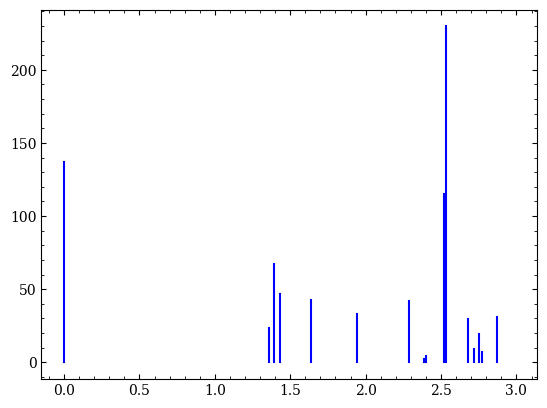

In [5]:
reflist = gen_reflection_list(HLIO,maxQmag=3.0)

#Combine the reflections with the same |Q| values
powder_reflist = []
qlist = []
hkllist=[]
sflist = []
for i,ref in enumerate(reflist):
    h,k,l=ref[0],ref[1],ref[2]
    Q = HLIO.Qmag_HKL(h,k,l)
    qlist.append(Q)
    hkllist.append([h,k,l])
    sflist.append(ref[3])
qlist = np.around(qlist,2) #Assume resolution of 0.01 Ang^-1
hkllist=np.array(hkllist)
sflist=np.array(sflist)
#organize all of this into a final array with columns [h,k,l,|Q|,SF^2]
hklQsf=[]
for q in np.unique(qlist):
    q_i = np.where(qlist==q)[0]
    sf = np.sum(sflist[q_i])
    hkl=np.abs(hkllist[q_i])[0]
    hklQsf.append([hkl[0],hkl[1],hkl[2],q,sf])

fig,ax =plt.subplots(1,1)
print('Structure factors for low-Q reflections in D3LiIr2O6')
print('H    K    L    |Q|    |SF|^2')
for i in range(len(hklQsf)):
    entry = hklQsf[i] 
    print(f"{entry[0]:.0f}    {entry[1]:.0f}    {entry[2]:.0f}    {entry[3]:.2f}   {entry[4]:.3f}" )
    
    ax.plot([entry[3],entry[3]],[0,entry[4]],color='b',ls='-')

26542.79043097593
26542.79043097593
23913.450973121977
23512.96533193802
23340.332831225878
23340.332831225878
23422.779527468938
23353.94188006815
23338.267455966063
23338.41499142688
23338.475694598445
23338.267455966063
3509.6064618612013
21583.1928269462
3509.6064618612013
1726.0906250353476
8492.814444966074
335.3666437022371
336.3741631972222
343.4080197724625
335.3666437022371
1678215030.8557608
5978414041.659955
335.3666437022371
131040487.97490323
59982935.843034744
10236.153177886577
2948.048688366616
497.06248257584446
335.0573540780486
333.9207631361548
333.9208948052238
333.92091948520846
333.9207631361548
732.3941987764979
1429.1346319175232
333.9207631361548
711.7857212959768
397.90668604710146
329.83927069757715
329.743533719458
329.7335246142251
329.73379090120244
329.7340841548433
23424.238177712294
329.7335246142251
515.6830013629074
1500.7609686461085
329.7335246142251
359.68030086435056
335.84669873490714
329.82517849754515
329.7412976644397
329.7334743287175
329.7

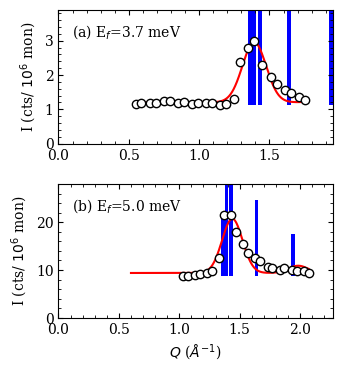

In [6]:
#Now develop a simple model of scattering to get normalizaion constant. 

def gaussian(x,sf,x0,sigma):
    return (sf/(np.sqrt(2.0*np.pi)* sigma))*np.exp(-(x-x0)**2 / (2.0*sigma**2))

params=lmfit.Parameters()
#Assume the form of a gaussian near each peak, scaled by the appropriate prefactors.
#The widths of these peaks should all be the same.
params.add('sigma',value=0.03,min=0.01,max=0.08)
params.add('inc_b',value=5.0,min=0,max=500) #also add linear background for incoherent scattering
params.add('Ascale',value=0.06,min=0.000,max=50)
params.add('delta',value=0.0,min=-0.05,max=0.05,vary=True)#Allow overall shift from misalignment
for i in range(len(hklQsf)):
    entry = hklQsf[i]
    hklstr = f"{entry[0]:.0f}"+'_'+f"{entry[1]:.0f}"+'_'+f"{entry[2]:.0f}"
    params.add('SF_'+hklstr,value=entry[4],vary=False)
    params.add('X0_'+hklstr,value=entry[3],vary=False)

def calc_powderline(params,q,hkllist,material):
    #Expects hkllist to have [h,k,l,Q,SF^2]
    I_out = np.zeros(len(q))
    sigma = params['sigma'].value
    scale = params['Ascale'].value
    inc_b = params['inc_b'].value
    delta=params['delta'].value
    for hkl_entry in hkllist:
        hklstr = f"{hkl_entry[0]:.0f}"+'_'+f"{hkl_entry[1]:.0f}"+'_'+f"{hkl_entry[2]:.0f}"
        q0 = params['X0_'+hklstr].value
        sf = params['SF_'+hklstr].value
        V0 = material.cell_vol
        prefactor = (2.0*np.pi)**3 / (4.0*np.pi*V0)
        #prefactor=1.0/prefactor
        #Normalization factor
        prefactor*=scale
        I_peak = gaussian(q-delta,sf,q0,sigma)
        I_peak*=prefactor
        #Account for powder averaging
        I_peak/=q**2
        I_out+=I_peak
    I_out+=scale*inc_b/(4.0*np.pi)
    return I_out

def chisqr(params,q,icut,err,hkllist,material):
    pow_calc = calc_powderline(params,q,hkllist,material)
    chisqr_list = np.abs(icut-pow_calc)**2 / (err**2)
    chisqr = np.nansum(chisqr_list)/len(chisqr_list)
    return chisqr 
#minimize chisqr, starting with 3.7 meV
result3 = lmfit.minimize(chisqr,params,method='powell',kws={'q':qcut3,'icut':icut3,'err':errcut3,'hkllist':hklQsf,\
                                                          'material':HLIO})

A_3p7 = result3.params['Ascale'].value
eval_q3 = np.linspace(0.6,np.max(qcut3),1000)
eval_result3 = calc_powderline(result3.params,q=eval_q3,hkllist=hklQsf,material=HLIO)
#eval_result3=A_3p7

result5 = lmfit.minimize(chisqr,params,method='powell',kws={'q':qcut5,'icut':icut5,'err':errcut5,'hkllist':hklQsf,'material':HLIO})

A_5p0 = result5.params['Ascale'].value

eval_q5 = np.linspace(0.6,np.max(qcut5),1000)
eval_result5 = calc_powderline(result5.params,q=eval_q5,hkllist=hklQsf,material=HLIO)
#eval_result5/=A_5p0

fig,ax = plt.subplots(2,1,figsize=(3.54,4))
fig.subplots_adjust(wspace=0.5,hspace=0.3)

ax[0].errorbar(qcut3,icut3,errcut3,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=3)
ax[1].errorbar(qcut5,icut5,errcut5,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=3)

for i in range(len(hklQsf)):
    entry = hklQsf[i]
    ax[0].bar(entry[3],entry[4]/entry[3]**2,0.03,\
              np.nanmin(icut3),color='b')
    ax[1].bar(entry[3],entry[4]/entry[3]**2,0.03,\
              np.nanmin(icut5),color='b')

ax[0].plot(eval_q3,eval_result3,'r-')
ax[1].plot(eval_q5,eval_result5,'r-')

ax[0].set_ylim(0,np.nanmax(icut3)*1.3)
ax[0].set_xlim(0,np.nanmax(eval_q3)+0.2)

ax[1].set_ylim(0,np.nanmax(icut5)*1.3)
ax[1].set_xlim(0,np.nanmax(eval_q5)+0.2)

ax[0].text(0.05,0.9,'(a) E$_f$=3.7 meV',transform=ax[0].transAxes,horizontalalignment='left',verticalalignment='top')
ax[1].text(0.05,0.9,'(b) E$_f$=5.0 meV',transform=ax[1].transAxes,horizontalalignment='left',verticalalignment='top')

ax[0].set_ylabel('I (cts/ $10^6$ mon)')
ax[1].set_ylabel('I (cts/ $10^6$ mon)')
ax[1].set_xlabel('$Q$ ($\AA^{-1}$)')


#Print the output normalization factors to take MACS data to per/Ir 

A_3p7 = result3.params['Ascale'].value
A_5p0 = result5.params['Ascale'].value

print(f"Scale for Ef=3.7 data ={A_3p7/4.0:.3e}")
print(f"Scale for Ef=5.0 data ={A_5p0/4.0:.3e}")

In [7]:
1.0/9.3e3

0.00010752688172043011

LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.06 seconds


(0.0, 0.5)

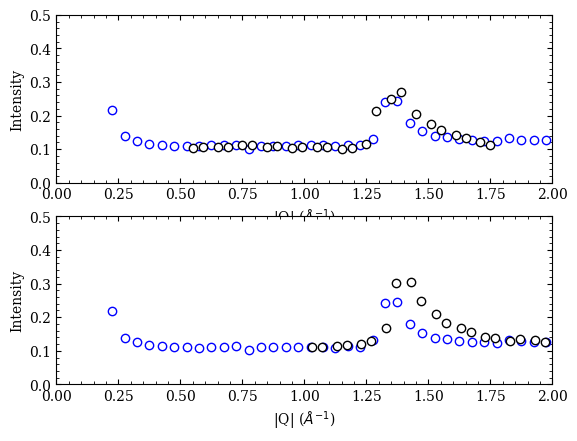

In [8]:
#Compare to normalizing to SEQ data

fig,ax = plt.subplots(2,1,subplot_kw={'projection':'mantid'})
int_seq = LoadMD('../MDHisto_files/seq30_int_elline.nxs')
dims = int_seq.getNonIntegratedDimensions()
q = mdu.dim2array(dims[0])
I = np.copy(int_seq.getSignalArray()).flatten()
Err = np.sqrt(np.copy(int_seq.getErrorSquaredArray())).flatten()
numEv = np.copy(int_seq.getNumEventsArray())[:,0]

I/=numEv
Err/=numEv
good_i = I>0 & ~np.isnan(I)

I=I[good_i]
Err=Err[good_i]
qseq=q[good_i]

#There is some flat background plus an overall scaling factor
scale3 = 9e-2
scale5 = 1.5e-2

inc_3 = 0.0
inc_5 = -0.02

ax[0].errorbar(qcut3,icut3*scale3+inc_3,errcut3*scale3,color='k',marker='o',\
               mfc='w',mec='k',ls=' ',capsize=3,zorder=10)
ax[1].errorbar(qcut5,icut5*scale5+inc_5,errcut5*scale5,color='k',marker='o',\
               mfc='w',mec='k',ls=' ',capsize=3,zorder=10)
ax[0].errorbar(int_seq,color='b',marker='o',mfc='w',mec='b',ls=' ')
ax[1].errorbar(int_seq,color='b',marker='o',mfc='w',mec='b',ls=' ')

ax[0].set_xlim(0,2)
ax[1].set_xlim(0,2)
ax[0].set_ylim(0,0.5)
ax[1].set_ylim(0,0.5)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 923
    # data points      = 1
    # variables        = 4
    chi-square         = 33464.9735
    reduced chi-square = 33464.9735
    Akaike info crit   = 18.4182546
    Bayesian info crit = 10.4182546
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    sigma:     0.08000000 (init = 0.03)
    inc_b:     286.447064 (init = 5)
    Ascale:    0.41123307 (init = 0.06)
    delta:     0.05000000 (init = 0)
    SF_0_0_0:  137.2647 (fixed)
    X0_0_0_0:  0 (fixed)
    SF_0_2_0:  23.80384 (fixed)
    X0_0_2_0:  1.36 (fixed)
    SF_0_0_1:  67.30745 (fixed)
    X0_0_0_1:  1.39 (fixed)
    SF_1_1_0:  46.53301 (fixed)
    X0_1_1_0:  1.43 (fixed)
    SF_1_1_1:  41.61319 (fixed)
    X0_

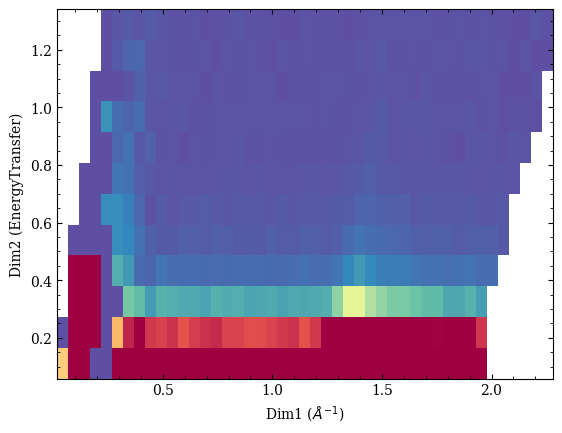

In [9]:
print(lmfit.fit_report(result5))

fig,ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.pcolormesh(mtd[keys[0]]*(A_3p7/4.0)/5.0,vmin=0,vmax=1,cmap='Spectral_r')

In [10]:
sigma = fwhm_3p7/2.35
a = 1.0/(2.0*sigma**2)
print(np.sqrt(np.pi/a))

0.20266356262974045


In [11]:
6.5e-1/1.5e-2

43.333333333333336

In [12]:
4.0*np.pi

12.566370614359172